In [1]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import math
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler
from scipy import stats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/international-football-results-from-1872-to-2017/shootouts.csv
/kaggle/input/international-football-results-from-1872-to-2017/results.csv


In [2]:
data = pd.read_csv('/kaggle/input/international-football-results-from-1872-to-2017/results.csv')
data.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [3]:
# deleting all data before the first World Cup, hence before 1930
drop_row_index = data[data['date'] < '1930-07-13'].index
data = data.drop(drop_row_index)

In [4]:
data.shape

(42107, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42107 entries, 1314 to 43420
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42107 non-null  object
 1   home_team   42107 non-null  object
 2   away_team   42107 non-null  object
 3   home_score  42107 non-null  int64 
 4   away_score  42107 non-null  int64 
 5   tournament  42107 non-null  object
 6   city        42107 non-null  object
 7   country     42107 non-null  object
 8   neutral     42107 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.9+ MB


In [6]:
# not really relevant, but looks cool
data.describe()

,home_score,away_score
count,42107.000000,42107.000000
mean,1.723585,1.163892
std,1.739261,1.381886
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [7]:
# same here
data.describe(include=['object', 'bool'])

,date,home_team,away_team,tournament,city,country,neutral
count,42107,42107,42107,42107,42107,42107,42107
unique,14356,305,301,127,1957,265,2
top,2012-02-29,Brazil,Uruguay,Friendly,Kuala Lumpur,United States,False
freq,66,566,480,16501,667,1237,31396


In [8]:
# checking if data is more or less full
data.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

The data is full!!!

Lets see how many friendly matches there are and remove them, because it is just not interesting:

In [9]:
data['tournament'].value_counts()

Friendly                                16501
FIFA World Cup qualification             7771
UEFA Euro qualification                  2594
African Cup of Nations qualification     1719
FIFA World Cup                            900
                                        ...  
Cup of Ancient Civilizations                2
Copa América qualification                  2
AFF Championship qualification              2
FIFA 75th Anniversary Cup                   1
TIFOCO Tournament                           1
Name: tournament, Length: 127, dtype: int64

In [10]:
# removing friendly matches
drop_row_index = data[data['tournament'] == 'Friendly'].index
data = data.drop(drop_row_index)

Lets remove tournaments that had less than 50 matches:

In [11]:
# getting the count of each value
value_counts = data['tournament'].value_counts()

# selecting the tournaments where less than 50 matches were played
tour = value_counts[value_counts < 100].index

# keeping rows where the tournament column is not in the tour variable
data = data[~data.tournament.isin(tour)]

Now let us visualize the filtered data and see which tournament was played most:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 [Text(0, 0, 'FIFA World Cup qualification'),
  Text(1, 0, 'UEFA Euro qualification'),
  Text(2, 0, 'African Cup of Nations qualification'),
  Text(3, 0, 'FIFA World Cup'),
  Text(4, 0, 'Copa América'),
  Text(5, 0, 'African Cup of Nations'),
  Text(6, 0, 'AFC Asian Cup qualification'),
  Text(7, 0, 'CECAFA Cup'),
  Text(8, 0, 'CFU Caribbean Cup qualification'),
  Text(9, 0, 'Merdeka Tournament'),
  Text(10, 0, 'Gulf Cup'),
  Text(11, 0, 'AFC Asian Cup'),
  Text(12, 0, 'Gold Cup'),
  Text(13, 0, 'Island Games'),
  Text(14, 0, 'UEFA Euro'),
  Text(15, 0, 'COSAFA Cup'),
  Text(16, 0, 'UEFA Nations League'),
  Text(17, 0, 'AFF Championship'),
  Text(18, 0, 'African Nations Championship'),
  Text(19, 0, 'Nordic Championship'),
  Text(20, 0, 'British Championship'),
  Text(21, 0, 'CFU Caribbean Cup'),
  Text

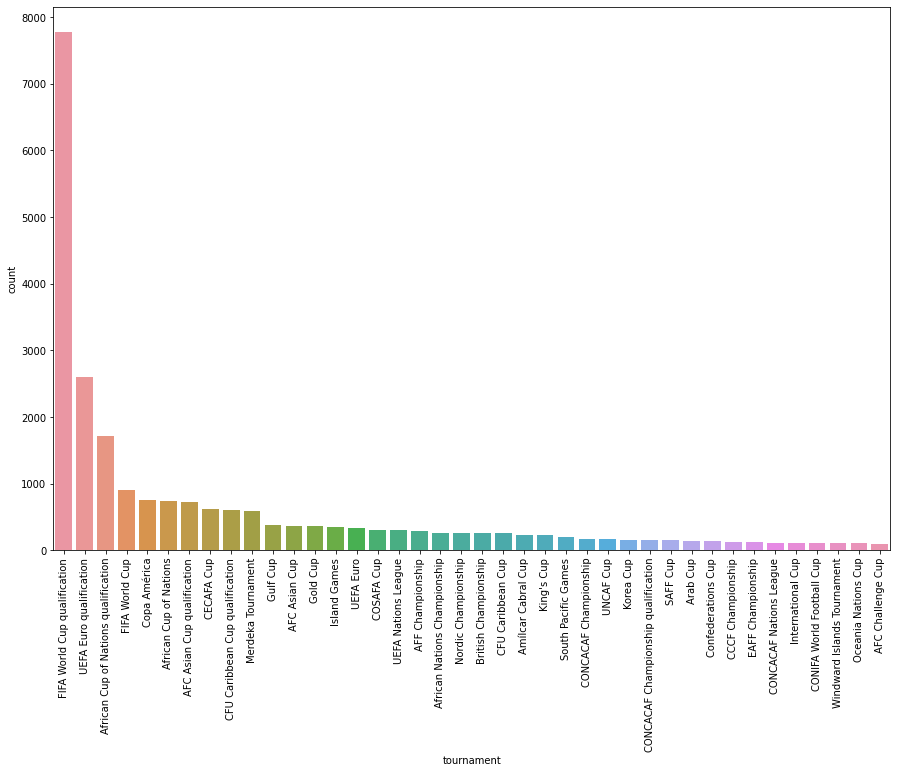

In [12]:
plt.figure(figsize = (15, 10))
sns.countplot(x="tournament", data = data, order = data['tournament'].value_counts().index)
plt.xticks(rotation = 90)

Obviously, the most played tournaments are the FIFA World Cup and the UEFA Champions league, followed by the African Cup of Nations (qualifications) and so on.

I also wanted to know how many games were actually "fair", i.e how many were played on neutral territory (it plays role):

In [13]:
data['neutral'].value_counts()

False    16025
True      7351
Name: neutral, dtype: int64

7351, not bad imho

Now let us take a look at our second dataset – shootouts.csv. I just want to now the country that won most.

In [14]:
data2 = pd.read_csv('/kaggle/input/international-football-results-from-1872-to-2017/shootouts.csv')
data2.head()

,date,home_team,away_team,winner
0,1967-08-22,India,Taiwan,Taiwan
1,1971-11-14,South Korea,Vietnam Republic,South Korea
2,1972-05-17,Thailand,South Korea,South Korea
3,1972-05-19,Thailand,Cambodia,Thailand
4,1973-07-26,Malaysia,Kuwait,Malaysia


In [15]:
data2['winner'].value_counts()

Egypt                13
South Korea          13
Argentina            11
South Africa         10
Zambia               10
                     ..
Libya                 1
Slovenia              1
Belarus               1
Serbia                1
Equatorial Guinea     1
Name: winner, Length: 131, dtype: int64